# Deep Q-Learning test with the Gymnasium Cart Pole Environment
Link: https://gymnasium.farama.org/environments/classic_control/cart_pole/

In [1]:
import gymnasium as gym
import numpy as np
from tensorflow import keras
from collections import deque
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython import display
%matplotlib inline


In [2]:
class Memory:
    def __init__(
        self,
        observation: np.ndarray,
        action: int,
        reward: float,
        new_observation: np.ndarray,
        done: bool,
    ) -> None:
        self.observation = observation
        self.action = action
        self.reward = reward
        self.new_observation = new_observation
        self.done = done

    def __str__(self) -> str:
        return f"Obv: {self.observation}, act: {self.action}, re: {self.reward}, NObv: {self.new_observation}, done: {self.done}"


In [3]:
class DQLAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        start_epsilon: float,
        end_epsilon: float,
        epsilon_decay: float,
        discount_factor: float,
    ) -> None:
        self.env = env

        self.learning_rate = learning_rate
        self.epsilon = start_epsilon
        self.end_epsilon = end_epsilon
        self.epsilon_decay = epsilon_decay
        self.discount_factor = discount_factor

        self.replay_menory = deque(maxlen=50_000)

        self.main_network = self.init_network()
        self.target_network = self.init_network()
        self.target_network.set_weights(self.main_network.get_weights())

        self.rewards = []

    def next_action(self, observation: np.ndarray) -> int:
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.main_network(observation.reshape(1, -1)))

    def _update(self, batch_size: int):
        MIN_REPLAY_SIZE = 1000
        if len(self.replay_menory) < MIN_REPLAY_SIZE:
            return

        batch: list[Memory] = random.sample(self.replay_menory, batch_size)

        observations = np.array([b.observation for b in batch])
        q_scores = self.main_network.predict(observations, verbose="0")
        new_observations = np.array([b.new_observation for b in batch])
        new_q_scores = self.target_network.predict(
            new_observations, verbose="0")

        X = []
        y = []
        for i, memory in enumerate(batch):
            max_future_q = memory.reward + (
                not memory.done
            ) * self.discount_factor * np.max(new_q_scores[i])

            current_q = q_scores[i]
            current_q[memory.action] = (1 - self.learning_rate) * current_q[
                memory.action
            ] + self.learning_rate * max_future_q

            X.append(memory.observation)
            y.append(current_q)

        self.main_network.fit(
            np.array(X), np.array(y), batch_size=batch_size, shuffle=True, verbose="0"
        )

    def decay_epsilon(self):
        self.epsilon = max(self.end_epsilon, self.epsilon - self.epsilon_decay)

    def train(self, n_episodes: int, batch_size: int):
        step_counter = 0
        for _ in range(n_episodes):
            done = False
            observation, _ = self.env.reset()
            total_reward = 0.0

            while not done:
                step_counter += 1
                # if render:
                #     self.env.render()

                action = self.next_action(observation)
                new_observation, reward, terminated, truncated, info = self.env.step(
                    action
                )
                done = terminated or truncated
                self.replay_menory.append(
                    Memory(
                        observation,
                        action,
                        reward,  # type: ignore
                        new_observation,
                        done,
                    )
                )
                observation = new_observation
                total_reward += reward

                if step_counter % 4 == 0 or done:
                    self._update(batch_size)

            print(total_reward)
            self.rewards.append(total_reward)

            if step_counter >= 100:
                self.target_network.set_weights(
                    self.main_network.get_weights())
                step_counter = 0
            self.decay_epsilon()

    def init_network(self) -> keras.Sequential:
        network = keras.Sequential()
        init = keras.initializers.HeUniform()
        # Input layer
        network.add(
            keras.layers.Dense(
                128,
                input_shape=self.env.observation_space.shape,
                activation="relu",
                kernel_initializer=init,
            )
        )

        # Hidden Layer
        network.add(keras.layers.Dense(
            128, activation="relu", kernel_initializer=init))

        # Output Layer
        network.add(
            keras.layers.Dense(
                self.env.action_space.n,  # type: ignore
                activation="linear",
                kernel_initializer=init,
            )
        )

        network.compile(
            loss=keras.losses.MeanSquaredError(),
            # Adam runs slow on M1, so legacy is used
            optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
            metrics=["accuracy"],
        )
        return network


In [4]:
n_episodes = 600
learning_rate = 0.005
start_epsilon = 0.95
end_epsilon = 0.05
epsilon_decay = 0.01

env = gym.make("CartPole-v0")

/Users/hwcrane/.local/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [5]:
agent = DQLAgent(
    env=env,
    learning_rate=learning_rate,
    start_epsilon=start_epsilon,
    end_epsilon=end_epsilon,
    epsilon_decay=epsilon_decay,
    discount_factor=0.99,
)

2023-08-12 18:22:02.241313: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-08-12 18:22:02.241338: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-08-12 18:22:02.241343: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-08-12 18:22:02.241378: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-12 18:22:02.241396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/hwcrane/.local/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, wh

In [6]:
agent.train(n_episodes=n_episodes, batch_size=128)

16.0
53.0
34.0
14.0
24.0
22.0
14.0
20.0
17.0
9.0
26.0
22.0
27.0
26.0
17.0
14.0
21.0
28.0
26.0
26.0
24.0
17.0
17.0
17.0
35.0
30.0
24.0
24.0
11.0
8.0
15.0
12.0
54.0
33.0
30.0
19.0
14.0
11.0
21.0
26.0
11.0
16.0
11.0
11.0
13.0


2023-08-12 18:22:03.152848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 18:22:03.325144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 18:22:03.534542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50.0
27.0
21.0
14.0
25.0
10.0
25.0
14.0
34.0
13.0
12.0
9.0
14.0
13.0
27.0
15.0
13.0
16.0
12.0
9.0
10.0
8.0
13.0
12.0
11.0
10.0
12.0
10.0
13.0
18.0
15.0
13.0
10.0
12.0
14.0
21.0
24.0
12.0
15.0
12.0
9.0
11.0
12.0
10.0
10.0
10.0
11.0
10.0
10.0
9.0
14.0
9.0
20.0
13.0
9.0
8.0
12.0
10.0
32.0
19.0
9.0
17.0
25.0
21.0
20.0
19.0
8.0
10.0
10.0
27.0
9.0
10.0
12.0
9.0
9.0
23.0
9.0
19.0
11.0
27.0
11.0
13.0
9.0
8.0
29.0
9.0
10.0
14.0
35.0
11.0
10.0
9.0
8.0
9.0
10.0
8.0
9.0
25.0
9.0
20.0
10.0
9.0
8.0
32.0
10.0
10.0
9.0
9.0
10.0
9.0
28.0
26.0
13.0
12.0
21.0
9.0
9.0
20.0
9.0
10.0
17.0
15.0
10.0
9.0
8.0
34.0
24.0
22.0
19.0
18.0
19.0
15.0
10.0
10.0
12.0
10.0
10.0
10.0
10.0
13.0
11.0
15.0
9.0
9.0
9.0
9.0
10.0
9.0
9.0
10.0
10.0
10.0
10.0
9.0
9.0
9.0
9.0
9.0
10.0
9.0
9.0
9.0
10.0
9.0
10.0
10.0
8.0
9.0
10.0
10.0
10.0
10.0
9.0
9.0
9.0
10.0
10.0
8.0
11.0
8.0
9.0
10.0
10.0
9.0
11.0
9.0
9.0
8.0
10.0
9.0
9.0
9.0
9.0
11.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
10.0
8.0
9.0
9.0
8.0
9.0
10.0
10.0
10.0
12.0
1

KeyboardInterrupt: 

In [ ]:
agent.epsilon

0.05

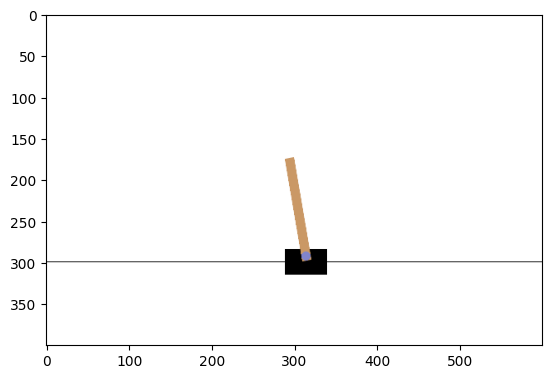

In [ ]:
agent.env = gym.make("CartPole-v1", render_mode="rgb_array")

observation, _ = agent.env.reset()
done = False

im = plt.imshow(agent.env.render())
while not done:
    im.set_data(agent.env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

    action = agent.next_action(observation)

    new_observation, reward, terminated, truncated, info = agent.env.step(action)

    done = terminated or truncated

    observation = new_observation

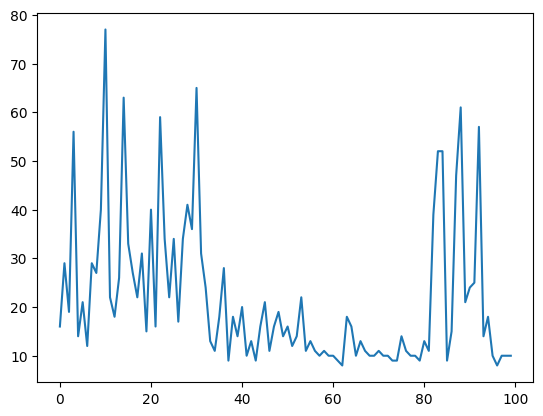

In [ ]:
plt.plot(agent.rewards)